In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install opencv-python mediapipe matplotlib scikit-learn pandas h5py
!pip install opencv-python tensorflow mediapipe numpy matplotlib scikit-learn pandas
!pip install numpy==1.23.5 tensorflow==2.12.0
!pip install tensorflow_model_optimization
!pip install --upgrade tensorflow

  Using cached tensorflow-2.19.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.10.0-py3-none-any.whl.metadata (6.0 kB)
  Using cached numpy-2.1.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached ml_dtypes-0.5.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (21 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 117.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 95.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 115.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Att

In [ ]:
# save_features_novel.py
import os
import numpy as np
import cv2
from pathlib import Path
import mediapipe as mp

mp_hands = mp.solutions.hands
mp_pose = mp.solutions.pose
mp_face = mp.solutions.face_mesh

hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5)
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5)
face = mp_face.FaceMesh(static_image_mode=False, max_num_faces=1, min_detection_confidence=0.5)

def preprocess_video(video_path, target_frames=16):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return None

    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if frame_count < 1:
        cap.release()
        return None

    # 126 (hands) + 33 (pose) + 180 (face: 60 points * 3 coords) = 339
    landmarks = np.zeros((target_frames, 339)) # Update total landmark size
    optical_flows = np.zeros((target_frames, 32, 32, 2))
    frame_indices = np.linspace(0, frame_count-1, target_frames, dtype=int)
    prev_gray = None

    for i, idx in enumerate(frame_indices):
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            continue
        frame = cv2.resize(frame, (448, 448))
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Hand landmarks (126)
        hand_landmarks = np.zeros(126)
        hand_results = hands.process(frame_rgb)
        if hand_results.multi_hand_landmarks:
            for hand_idx, hand_landmark in enumerate(hand_results.multi_hand_landmarks[:2]):
                start_idx = hand_idx * 63
                for j, lm in enumerate(hand_landmark.landmark[:21]):
                    hand_landmarks[start_idx + j*3] = lm.x
                    hand_landmarks[start_idx + j*3 + 1] = lm.y
                    hand_landmarks[start_idx + j*3 + 2] = lm.z

        # Pose landmarks (33)
        pose_landmarks = np.zeros(33)
        pose_results = pose.process(frame_rgb)
        if pose_results.pose_landmarks:
            key_indices = [11,12,13,14,15,16,23,24,25,26,27]
            for j, idx2 in enumerate(key_indices):
                lm = pose_results.pose_landmarks.landmark[idx2]
                pose_landmarks[j*3] = lm.x
                pose_landmarks[j*3 + 1] = lm.y
                pose_landmarks[j*3 + 2] = lm.z

        # Face landmarks (180: 60 keypoints * 3 coords)
        # Changed size to 180 to accommodate 60 points (40 keypoints + 20 lips) with 3 coords each
        face_landmarks = np.zeros(180)
        face_results = face.process(frame_rgb)
        if face_results.multi_face_landmarks:
            # Use the same key_indices and lip_indices, but the loop correctly populates
            # the larger face_landmarks array. The enumerate(key_indices + lip_indices)
            # will produce j from 0 to 59. j*3+2 will go up to 59*3+2 = 177+2 = 179,
            # which is within the bounds of the size 180 array.
            key_indices = list(range(0, 40))
            lip_indices = list(range(61, 81))
            for j, idx3 in enumerate(key_indices + lip_indices):
                if idx3 < len(face_results.multi_face_landmarks[0].landmark):
                    lm = face_results.multi_face_landmarks[0].landmark[idx3]
                    face_landmarks[j*3] = lm.x
                    face_landmarks[j*3+1] = lm.y
                    face_landmarks[j*3+2] = lm.z

        # Combine and normalize
        all_landmarks = np.concatenate([hand_landmarks, pose_landmarks, face_landmarks])
        non_zero = all_landmarks != 0
        if non_zero.any():
            mean = all_landmarks[non_zero].mean()
            std = all_landmarks[non_zero].std()
            if std > 0:
                all_landmarks[non_zero] = (all_landmarks[non_zero] - mean)/std
        landmarks[i] = all_landmarks

        # Optical flow
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        if prev_gray is not None:
            flow = cv2.calcOpticalFlowFarneback(
                prev_gray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0
            )
            # Resize flow to 32x32
            optical_flows[i] = cv2.resize(flow, (32, 32))
        prev_gray = gray

    cap.release()
    optical_flows_flat = optical_flows.reshape(target_frames, -1)  # 16x2048
    # Features size is 16x(339 + 2048) = 16x2387
    features = np.concatenate([landmarks, optical_flows_flat], axis=1)  # 16x2387
    return features

class FeatureExtractor:
    def __init__(self, data_dir, output_dir="preprocessed_features"):
        self.data_dir = data_dir
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)

    def process_dataset(self):
        feature_dir = os.path.join(self.output_dir, "features")
        label_dir = os.path.join(self.output_dir, "labels")
        os.makedirs(feature_dir, exist_ok=True)
        os.makedirs(label_dir, exist_ok=True)
        progress_file = os.path.join(self.output_dir, "progress.txt")
        processed = set()
        if os.path.exists(progress_file):
            with open(progress_file, 'r') as f:
                processed = set(f.read().splitlines())
        for root, _, files in os.walk(self.data_dir):
            for file in files:
                if file.endswith('.mp4'):
                    video_path = os.path.join(root, file)
                    rel_path = os.path.relpath(video_path, self.data_dir)
                    save_name = rel_path.replace(os.path.sep, "_").replace(".mp4", "")
                    if save_name in processed:
                        continue
                    features = preprocess_video(video_path)
                    if features is not None:
                        np.save(os.path.join(feature_dir, save_name), features)
                        label = Path(root).name
                        np.save(os.path.join(label_dir, save_name), label)
                        with open(progress_file, 'a') as f:
                            f.write(f"{save_name}\n")

if __name__ == "__main__":
    extractor = FeatureExtractor(
        data_dir="/content/drive/MyDrive/completed2/train",
        output_dir="/content/drive/MyDrive/completed2/preprocessed_features"
    )
    extractor.process_dataset()
    print("Feature extraction completed!")

Feature extraction completed!


In [ ]:
# signer independent split
import os
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from pathlib import Path

def load_and_split(dataset_root, val_size=0.15, random_state=42):
    features = []
    labels = []
    groups = []  # signer IDs
    label_map = {}
    current_label = 0

    # Load all .npy files from class folders
    for class_name in os.listdir(dataset_root):
        class_path = os.path.join(dataset_root, class_name)
        if not os.path.isdir(class_path):
            continue

        # Assign numerical label
        if class_name not in label_map:
            label_map[class_name] = current_label
            current_label += 1

        # Process each signer's videos
        for signer_id in os.listdir(class_path):
            signer_path = os.path.join(class_path, signer_id)
            if not os.path.isdir(signer_path):
                continue

            for file in os.listdir(signer_path):
                if file.endswith('.npy'):
                    data = np.load(os.path.join(signer_path, file))
                    features.append(data)
                    labels.append(label_map[class_name])
                    groups.append(signer_id)  # Use signer ID for grouping

    features = np.array(features)
    labels = np.array(labels)
    groups = np.array(groups)

    # Signer-independent split
    splitter = GroupShuffleSplit(n_splits=1, test_size=val_size, random_state=random_state)
    train_idx, val_idx = next(splitter.split(features, labels, groups))

    # Save splits
    os.makedirs("dataset_splits", exist_ok=True)
    np.save("dataset_splits/X_train.npy", features[train_idx])
    np.save("dataset_splits/X_val.npy", features[val_idx])
    np.save("dataset_splits/y_train.npy", labels[train_idx])
    np.save("dataset_splits/y_val.npy", labels[val_idx])

    # Save label mapping
    with open("dataset_splits/label_map.txt", "w") as f:
        for name, idx in label_map.items():
            f.write(f"{name}:{idx}\n")

    print(f"✅ Split complete. Train: {len(train_idx)}, Val: {len(val_idx)}")

if __name__ == "__main__":
    dataset_root = "/content/drive/MyDrive/completed2/preprocessed_features/features"  # Update this path
    load_and_split(dataset_root)

✅ Split complete. Train: 1001, Val: 286


In [ ]:
# signer dependent split
import os
import numpy as np
from sklearn.model_selection import train_test_split

class DatasetPreparer:
    def __init__(self, feature_dir, label_dir):
        self.feature_dir = feature_dir
        self.label_dir = label_dir

    def load_and_split(self, val_size=0.2, random_state=42):
        """Load features from nested structure and split into train/val"""
        features = []
        labels = []
        label_map = {}
        current_id = 0

        # Iterate through class folders
        for class_name in sorted(os.listdir(self.feature_dir)):
            class_path = os.path.join(self.feature_dir, class_name)

            if not os.path.isdir(class_path):
                continue

            # Create label mapping
            if class_name not in label_map:
                label_map[class_name] = current_id
                current_id += 1

            # Iterate through person folders
            for person_folder in sorted(os.listdir(class_path)):
                person_path = os.path.join(class_path, person_folder)

                if not os.path.isdir(person_path):
                    continue

                # Load all .npy files for this person
                for feat_file in sorted(os.listdir(person_path)):
                    if feat_file.endswith('.npy'):
                        feature_path = os.path.join(person_path, feat_file)

                        # Construct expected label path
                        base_name = os.path.splitext(feat_file)[0]
                        label_path = os.path.join(self.label_dir, class_name,
                                                person_folder, base_name + '.npy')

                        if os.path.exists(label_path):
                            features.append(np.load(feature_path))
                            labels.append(label_map[class_name])

        features = np.array(features)
        labels = np.array(labels)

        # Save full data for k-fold
        os.makedirs("dataset_splits", exist_ok=True)
        np.save("dataset_splits/X_all.npy", features)
        np.save("dataset_splits/y_all.npy", labels)

        # Create train/val split (stratified by class)
        X_train, X_val, y_train, y_val = train_test_split(
            features, labels, test_size=val_size,
            random_state=random_state, stratify=labels
        )

        # Save basic train/val splits
        np.save("dataset_splits/X_train.npy", X_train)
        np.save("dataset_splits/X_val.npy", X_val)
        np.save("dataset_splits/y_train.npy", y_train)
        np.save("dataset_splits/y_val.npy", y_val)

        # Save label mapping
        with open("dataset_splits/label_map.txt", 'w') as f:
            for label, idx in label_map.items():
                f.write(f"{label}:{idx}\n")

        print(f"\n✅ Dataset prepared with {len(label_map)} classes")
        print(f"🟢 Train: {len(X_train)}, 🔵 Val: {len(X_val)}, 🟡 Total: {len(features)}")
        print(f"Class distribution:\n{np.unique(labels, return_counts=True)}")

if __name__ == "__main__":
    preparer = DatasetPreparer(
        feature_dir="/content/drive/MyDrive/completed2/preprocessed_features/features",
        label_dir="/content/drive/MyDrive/completed2/preprocessed_features/labels"
    )
    preparer.load_and_split()


✅ Dataset prepared with 11 classes
🟢 Train: 1028, 🔵 Val: 258, 🟡 Total: 1286
Class distribution:
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([117, 117, 117, 117, 117, 117, 117, 117, 117, 116, 117]))


In [ ]:
pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.9 MB/s eta 0:00:00


Starting training...
Epoch 1/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.0918 - loss: 2.4199

8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 460ms/step - accuracy: 0.0929 - loss: 2.4202 - val_accuracy: 0.1473 - val_loss: 2.3527 - learning_rate: 0.0010
Epoch 2/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.1028 - loss: 2.3952

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - accuracy: 0.1048 - loss: 2.3942 - val_accuracy: 0.1899 - val_loss: 2.3289 - learning_rate: 0.0010
Epoch 3/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.1873 - loss: 2.3508

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 204ms/step - accuracy: 0.1877 - loss: 2.3514 - val_accuracy: 0.1938 - val_loss: 2.3012 - learning_rate: 0.0010
Epoch 4/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.1578 - loss: 2.3366

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 274ms/step - accuracy: 0.1611 - loss: 2.3351 - val_accuracy: 0.2093 - val_loss: 2.2646 - learning_rate: 0.0010
Epoch 5/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.2243 - loss: 2.3076

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - accuracy: 0.2227 - loss: 2.3086 - val_accuracy: 0.2403 - val_loss: 2.2188 - learning_rate: 0.0010
Epoch 6/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.2197 - loss: 2.2570

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.2196 - loss: 2.2577 - val_accuracy: 0.2558 - val_loss: 2.1551 - learning_rate: 0.0010
Epoch 7/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.2529 - loss: 2.2637 - val_accuracy: 0.2481 - val_loss: 2.1073 - learning_rate: 0.0010
Epoch 8/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.1750 - loss: 2.2421

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - accuracy: 0.1777 - loss: 2.2402 - val_accuracy: 0.3178 - val_loss: 2.0440 - learning_rate: 0.0010
Epoch 9/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.2592 - loss: 2.1407 - val_accuracy: 0.2946 - val_loss: 1.9914 - learning_rate: 0.0010
Epoch 10/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.2420 - loss: 2.1919

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - accuracy: 0.2455 - loss: 2.1854 - val_accuracy: 0.3372 - val_loss: 1.9377 - learning_rate: 0.0010
Epoch 11/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.2722 - loss: 2.0970 - val_accuracy: 0.3295 - val_loss: 1.8523 - learning_rate: 0.0010
Epoch 12/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.3302 - loss: 2.0811

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 247ms/step - accuracy: 0.3312 - loss: 2.0774 - val_accuracy: 0.3682 - val_loss: 1.8254 - learning_rate: 0.0010
Epoch 13/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.3462 - loss: 1.9798

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 240ms/step - accuracy: 0.3467 - loss: 1.9770 - val_accuracy: 0.3953 - val_loss: 1.7746 - learning_rate: 0.0010
Epoch 14/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.3305 - loss: 1.9960

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 0.3328 - loss: 1.9942 - val_accuracy: 0.4302 - val_loss: 1.7379 - learning_rate: 0.0010
Epoch 15/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.3127 - loss: 2.0078

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.3144 - loss: 2.0074 - val_accuracy: 0.4419 - val_loss: 1.6815 - learning_rate: 0.0010
Epoch 16/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.3056 - loss: 2.0434 - val_accuracy: 0.4302 - val_loss: 1.6228 - learning_rate: 0.0010
Epoch 17/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - accuracy: 0.4025 - loss: 1.9158 - val_accuracy: 0.4341 - val_loss: 1.6587 - learning_rate: 0.0010
Epoch 18/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.4618 - loss: 1.9027 - val_accuracy: 0.4147 - val_loss: 1.6652 - learning_rate: 0.0010
Epoch 19/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.3771 - loss: 1.9419

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - accuracy: 0.3781 - loss: 1.9392 - val_accuracy: 0.4496 - val_loss: 1.5892 - learning_rate: 0.0010
Epoch 20/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.3707 - loss: 1.9280

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 212ms/step - accuracy: 0.3742 - loss: 1.9213 - val_accuracy: 0.4806 - val_loss: 1.5079 - learning_rate: 0.0010
Epoch 21/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.3767 - loss: 1.7882

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/step - accuracy: 0.3777 - loss: 1.7899 - val_accuracy: 0.5078 - val_loss: 1.4596 - learning_rate: 0.0010
Epoch 22/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.4566 - loss: 1.6989

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.4597 - loss: 1.6976 - val_accuracy: 0.5620 - val_loss: 1.3833 - learning_rate: 0.0010
Epoch 23/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.4990 - loss: 1.6940

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - accuracy: 0.5000 - loss: 1.6969 - val_accuracy: 0.5814 - val_loss: 1.3339 - learning_rate: 0.0010
Epoch 24/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.5278 - loss: 1.6661

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - accuracy: 0.5299 - loss: 1.6656 - val_accuracy: 0.5930 - val_loss: 1.2686 - learning_rate: 0.0010
Epoch 25/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - accuracy: 0.5129 - loss: 1.6784 - val_accuracy: 0.5233 - val_loss: 1.3181 - learning_rate: 0.0010
Epoch 26/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 0.6055 - loss: 1.6000 - val_accuracy: 0.5659 - val_loss: 1.2440 - learning_rate: 0.0010
Epoch 27/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5344 - loss: 1.5891

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step - accuracy: 0.5367 - loss: 1.5879 - val_accuracy: 0.5969 - val_loss: 1.1883 - learning_rate: 0.0010
Epoch 28/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5442 - loss: 1.6414

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.5432 - loss: 1.6352 - val_accuracy: 0.6008 - val_loss: 1.1648 - learning_rate: 0.0010
Epoch 29/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.4828 - loss: 1.6662

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 272ms/step - accuracy: 0.4895 - loss: 1.6591 - val_accuracy: 0.6318 - val_loss: 1.1298 - learning_rate: 0.0010
Epoch 30/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.5806 - loss: 1.5218

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - accuracy: 0.5833 - loss: 1.5161 - val_accuracy: 0.6473 - val_loss: 1.0764 - learning_rate: 0.0010
Epoch 31/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - accuracy: 0.6348 - loss: 1.4960 - val_accuracy: 0.6318 - val_loss: 1.1191 - learning_rate: 0.0010
Epoch 32/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - accuracy: 0.5932 - loss: 1.4395 - val_accuracy: 0.6279 - val_loss: 1.0942 - learning_rate: 0.0010
Epoch 33/120
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.6556 - loss: 1.4612

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - accuracy: 0.6503 - loss: 1.4628 - val_accuracy: 0.6938 - val_loss: 1.0253 - learning_rate: 0.0010
Epoch 34/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.6963 - loss: 1.3356 - val_accuracy: 0.6899 - val_loss: 0.9845 - learning_rate: 0.0010
Epoch 35/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 201ms/step - accuracy: 0.6725 - loss: 1.3674 - val_accuracy: 0.6512 - val_loss: 0.9632 - learning_rate: 0.0010
Epoch 36/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.6915 - loss: 1.2883

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - accuracy: 0.6902 - loss: 1.2942 - val_accuracy: 0.7132 - val_loss: 0.8731 - learning_rate: 0.0010
Epoch 37/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - accuracy: 0.6941 - loss: 1.3282 - val_accuracy: 0.6899 - val_loss: 0.9724 - learning_rate: 0.0010
Epoch 38/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.7031 - loss: 1.3017

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 241ms/step - accuracy: 0.7059 - loss: 1.2955 - val_accuracy: 0.7326 - val_loss: 0.8445 - learning_rate: 0.0010
Epoch 39/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.7992 - loss: 1.1754

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - accuracy: 0.7972 - loss: 1.1792 - val_accuracy: 0.7481 - val_loss: 0.8036 - learning_rate: 0.0010
Epoch 40/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.7258 - loss: 1.2234 - val_accuracy: 0.7481 - val_loss: 0.8157 - learning_rate: 0.0010
Epoch 41/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.7222 - loss: 1.2007

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.7231 - loss: 1.2010 - val_accuracy: 0.7636 - val_loss: 0.7758 - learning_rate: 0.0010
Epoch 42/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - accuracy: 0.7092 - loss: 1.2887 - val_accuracy: 0.7442 - val_loss: 0.8624 - learning_rate: 0.0010
Epoch 43/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - accuracy: 0.7677 - loss: 1.1709 - val_accuracy: 0.7209 - val_loss: 0.8457 - learning_rate: 0.0010
Epoch 44/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.7211 - loss: 1.2796 - val_accuracy: 0.7132 - val_loss: 0.8325 - learning_rate: 0.0010
Epoch 45/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - accuracy: 0.7118 - loss: 1.2318 - val_accuracy: 0.7209 - val_loss: 0.8076 - learning_rate: 0.0010
Epoch 46/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - accuracy: 0.6947 - loss: 1.2682 - val_accuracy: 0.7287 - val_loss: 0.8141 - learning_rate: 0.0010
Epoch 47/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - accuracy: 0.8013 - loss: 1.1556 - val_accuracy:

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.8273 - loss: 1.0855 - val_accuracy: 0.7713 - val_loss: 0.7126 - learning_rate: 0.0010
Epoch 53/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.8270 - loss: 1.0470 - val_accuracy: 0.7519 - val_loss: 0.7280 - learning_rate: 0.0010
Epoch 54/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.7504 - loss: 1.1283 - val_accuracy: 0.7674 - val_loss: 0.7147 - learning_rate: 0.0010
Epoch 55/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.7918 - loss: 1.1057

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 269ms/step - accuracy: 0.7954 - loss: 1.0996 - val_accuracy: 0.7868 - val_loss: 0.6908 - learning_rate: 0.0010
Epoch 56/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.7584 - loss: 1.1277

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 241ms/step - accuracy: 0.7601 - loss: 1.1221 - val_accuracy: 0.7984 - val_loss: 0.6538 - learning_rate: 0.0010
Epoch 57/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - accuracy: 0.7917 - loss: 1.0874 - val_accuracy: 0.7868 - val_loss: 0.6907 - learning_rate: 0.0010
Epoch 58/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.8099 - loss: 1.0657 - val_accuracy: 0.7984 - val_loss: 0.6607 - learning_rate: 0.0010
Epoch 59/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - accuracy: 0.8380 - loss: 1.0353 - val_accuracy: 0.7984 - val_loss: 0.6626 - learning_rate: 0.0010
Epoch 60/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.8617 - loss: 1.0136

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - accuracy: 0.8576 - loss: 1.0153 - val_accuracy: 0.8140 - val_loss: 0.6021 - learning_rate: 0.0010
Epoch 61/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8828 - loss: 0.9669

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.8806 - loss: 0.9696 - val_accuracy: 0.8333 - val_loss: 0.5793 - learning_rate: 0.0010
Epoch 62/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8431 - loss: 1.0130

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.8439 - loss: 1.0114 - val_accuracy: 0.8450 - val_loss: 0.5548 - learning_rate: 0.0010
Epoch 63/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step - accuracy: 0.8652 - loss: 0.9706 - val_accuracy: 0.8372 - val_loss: 0.5758 - learning_rate: 0.0010
Epoch 64/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 244ms/step - accuracy: 0.8294 - loss: 1.0330 - val_accuracy: 0.7984 - val_loss: 0.5750 - learning_rate: 0.0010
Epoch 65/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.8355 - loss: 1.0192 - val_accuracy: 0.8140 - val_loss: 0.5645 - learning_rate: 0.0010
Epoch 66/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.9063 - loss: 0.9200 - val_accuracy: 0.8295 - val_loss: 0.6066 - learning_rate: 0.0010
Epoch 67/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - accuracy: 0.8241 - loss: 0.9769 - val_accuracy: 0.8295 - val_loss: 0.6161 - learning_rate: 0.0010
Epoch 68/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - accuracy: 0.8141 - loss: 1.0316 - val_accuracy:

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - accuracy: 0.9006 - loss: 0.9049 - val_accuracy: 0.8566 - val_loss: 0.5164 - learning_rate: 2.0000e-04
Epoch 81/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 252ms/step - accuracy: 0.9066 - loss: 0.8814 - val_accuracy: 0.8411 - val_loss: 0.5071 - learning_rate: 2.0000e-04
Epoch 82/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - accuracy: 0.8954 - loss: 0.9177 - val_accuracy: 0.8372 - val_loss: 0.5032 - learning_rate: 2.0000e-04
Epoch 83/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.9229 - loss: 0.8986 - val_accuracy: 0.8372 - val_loss: 0.5061 - learning_rate: 2.0000e-04
Epoch 84/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.8769 - loss: 0.9079 - val_accuracy: 0.8411 - val_loss: 0.5003 - learning_rate: 2.0000e-04
Epoch 85/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.9277 - loss: 0.8828 - val_accuracy: 0.8411 - val_loss: 0.4936 - learning_rate: 2.0000e-04
Epoch 86/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.9083 - loss

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - accuracy: 0.9146 - loss: 0.9017 - val_accuracy: 0.8605 - val_loss: 0.4744 - learning_rate: 2.0000e-04
Epoch 92/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9051 - loss: 0.8800

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.9074 - loss: 0.8762 - val_accuracy: 0.8682 - val_loss: 0.4689 - learning_rate: 2.0000e-04
Epoch 93/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.8962 - loss: 0.8990 - val_accuracy: 0.8605 - val_loss: 0.4657 - learning_rate: 2.0000e-04
Epoch 94/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - accuracy: 0.8586 - loss: 0.9972 - val_accuracy: 0.8527 - val_loss: 0.4681 - learning_rate: 2.0000e-04
Epoch 95/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.8769 - loss: 0.9116 - val_accuracy: 0.8527 - val_loss: 0.4699 - learning_rate: 2.0000e-04
Epoch 96/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - accuracy: 0.9244 - loss: 0.8630 - val_accuracy: 0.8643 - val_loss: 0.4681 - learning_rate: 2.0000e-04
Epoch 97/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8873 - loss: 0.9053

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - accuracy: 0.8877 - loss: 0.9066 - val_accuracy: 0.8798 - val_loss: 0.4667 - learning_rate: 2.0000e-04
Epoch 98/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - accuracy: 0.9494 - loss: 0.8144 - val_accuracy: 0.8721 - val_loss: 0.4697 - learning_rate: 2.0000e-04
Epoch 99/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 252ms/step - accuracy: 0.9119 - loss: 0.8880 - val_accuracy: 0.8721 - val_loss: 0.4704 - learning_rate: 2.0000e-04
Epoch 100/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - accuracy: 0.9230 - loss: 0.8342 - val_accuracy: 0.8721 - val_loss: 0.4690 - learning_rate: 2.0000e-04
Epoch 101/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 0.9323 - loss: 0.8737 - val_accuracy: 0.8760 - val_loss: 0.4607 - learning_rate: 2.0000e-04
Epoch 102/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.9277 - loss: 0.8444 - val_accuracy: 0.8760 - val_loss: 0.4593 - learning_rate: 2.0000e-04
Epoch 103/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.9118 - 

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 266ms/step - accuracy: 0.9255 - loss: 0.8527 - val_accuracy: 0.8876 - val_loss: 0.4631 - learning_rate: 2.0000e-04
Epoch 112/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9172 - loss: 0.8944

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.9147 - loss: 0.8928 - val_accuracy: 0.8915 - val_loss: 0.4616 - learning_rate: 2.0000e-04
Epoch 113/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step - accuracy: 0.9184 - loss: 0.8435 - val_accuracy: 0.8915 - val_loss: 0.4602 - learning_rate: 4.0000e-05
Epoch 114/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.9120 - loss: 0.8662 - val_accuracy: 0.8915 - val_loss: 0.4587 - learning_rate: 4.0000e-05
Epoch 115/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9524 - loss: 0.8011

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step - accuracy: 0.9512 - loss: 0.8026 - val_accuracy: 0.8953 - val_loss: 0.4565 - learning_rate: 4.0000e-05
Epoch 116/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 268ms/step - accuracy: 0.8964 - loss: 0.8915 - val_accuracy: 0.8953 - val_loss: 0.4527 - learning_rate: 4.0000e-05
Epoch 117/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.8996 - loss: 0.8797 - val_accuracy: 0.8953 - val_loss: 0.4504 - learning_rate: 4.0000e-05
Epoch 118/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.9430 - loss: 0.8048 - val_accuracy: 0.8915 - val_loss: 0.4500 - learning_rate: 4.0000e-05
Epoch 119/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.9245 - loss: 0.8328 - val_accuracy: 0.8876 - val_loss: 0.4505 - learning_rate: 4.0000e-05
Epoch 120/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.9235 - loss: 0.8483 - val_accuracy: 0.8915 - val_loss: 0.4521 - learning_rate: 4.0000e-05

Training history saved to training_history.pkl
Error loading best model

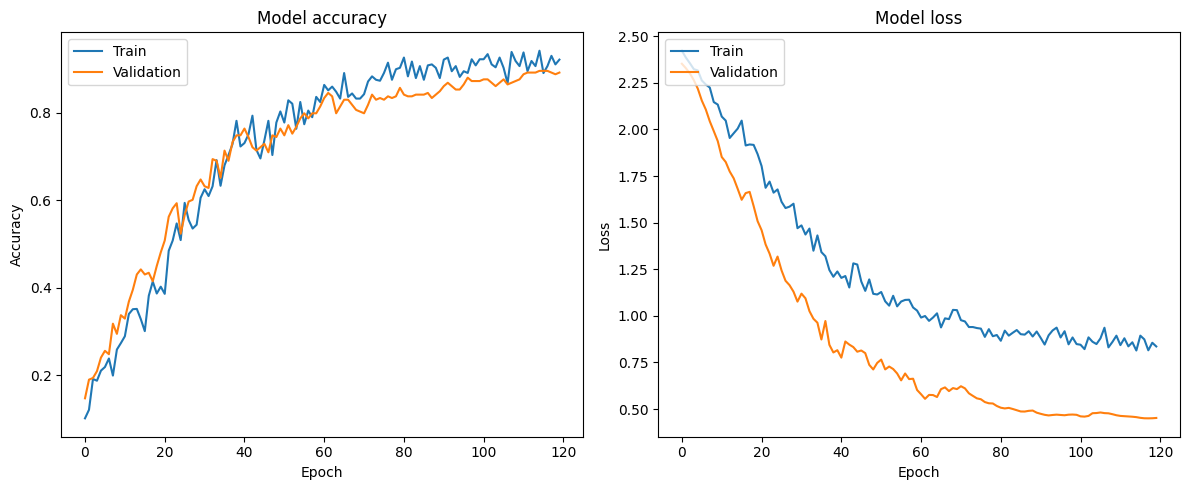

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step


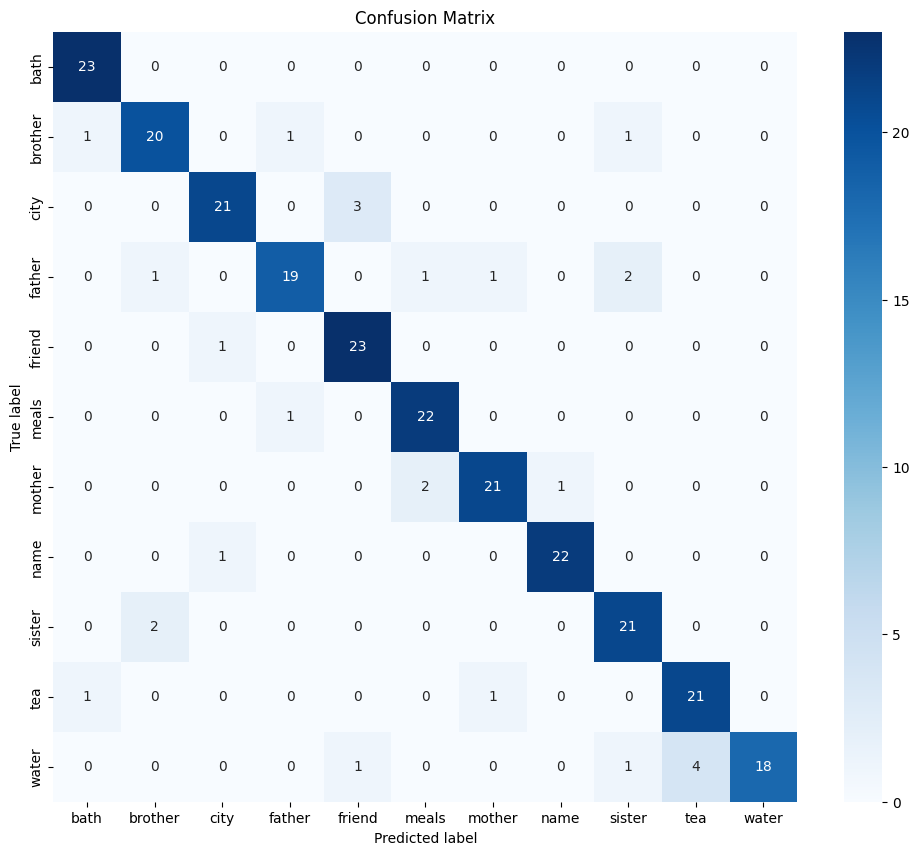


Classification Report:
              precision    recall  f1-score   support

        bath       0.92      1.00      0.96        23
     brother       0.87      0.87      0.87        23
        city       0.91      0.88      0.89        24
      father       0.90      0.79      0.84        24
      friend       0.85      0.96      0.90        24
       meals       0.88      0.96      0.92        23
      mother       0.91      0.88      0.89        24
        name       0.96      0.96      0.96        23
      sister       0.84      0.91      0.88        23
         tea       0.84      0.91      0.88        23
       water       1.00      0.75      0.86        24

    accuracy                           0.90       258
   macro avg       0.90      0.90      0.89       258
weighted avg       0.90      0.90      0.89       258



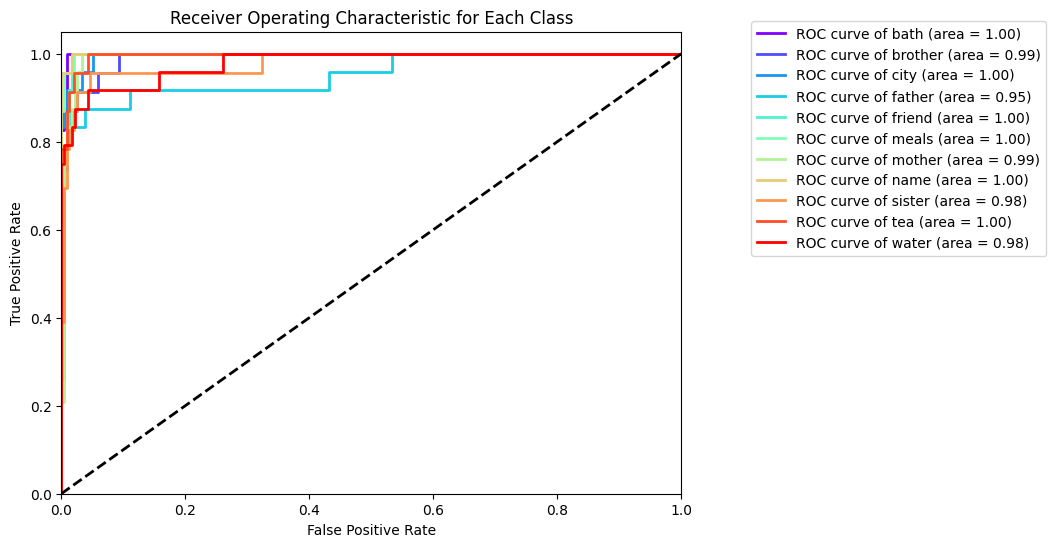

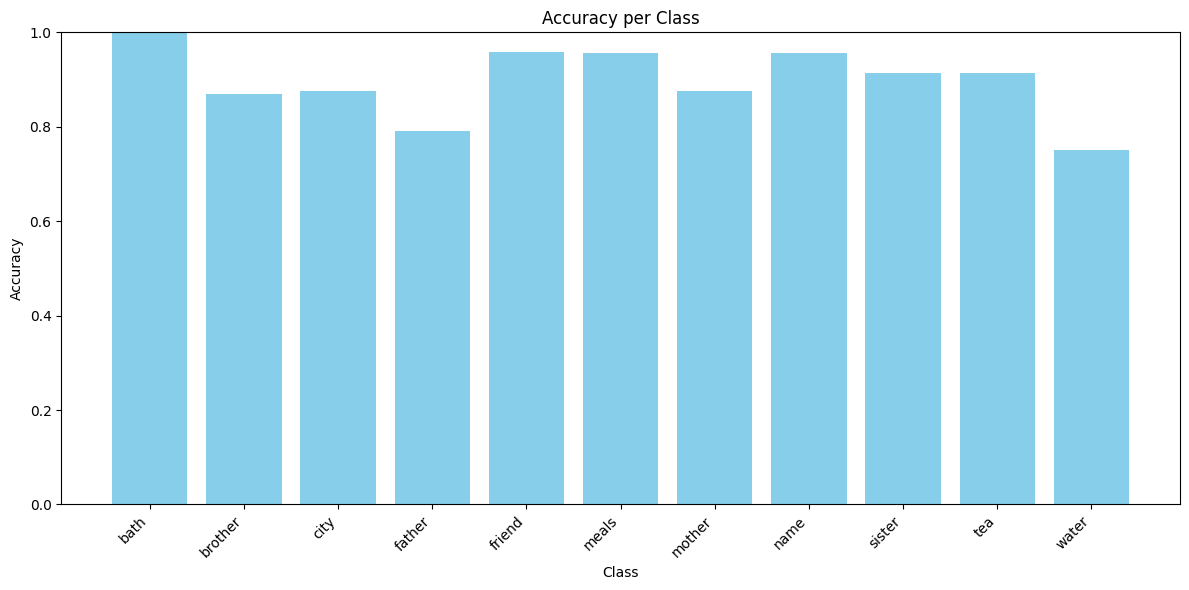


Final model saved to /content/drive/MyDrive/completed2/final_model.h5


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
from sklearn.utils.class_weight import compute_class_weight
import pickle
import os
import keras.ops
from datetime import datetime
from kerastuner import HyperModel, RandomSearch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

# Configuration class for easy parameter management
class TrainingConfig:
    def __init__(self):
        # Training configuration
        self.batch_size = 32
        self.epochs = 120
        self.initial_learning_rate = 0.001
        self.label_smoothing_epsilon = 0.1
        self.gradient_accumulation_steps = 4  # For gradient accumulation
        # Path configuration
        self.final_model_dir = "/content/drive/MyDrive/completed2/saved_models"
        self.final_model_name = "/content/drive/MyDrive/completed2/final_model.h5"
        # Hyperparameter tuning
        self.enable_hyperparameter_tuning = False
        self.max_trials = 10
        self.executions_per_trial = 2

config = TrainingConfig()

# Custom LSTM layer (without pruning)
@tf.keras.utils.register_keras_serializable()
class CustomLSTM(layers.LSTM):
    pass

# HyperModel class for hyperparameter tuning
class SignLanguageHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        inp = layers.Input(shape=self.input_shape)

        # Hyperparameters to tune
        lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=32)
        dense_units = hp.Int('dense_units', min_value=64, max_value=256, step=64)
        dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.6, step=0.1)
        learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

        # Stream 1: Landmarks
        x1 = layers.Lambda(lambda x: x[:, :, :299])(inp)
        x1 = layers.Conv1D(64, 5, padding='same', activation='swish')(x1)
        x1 = layers.BatchNormalization()(x1)
        x1 = transformer_block(x1, num_heads=4, dropout_rate=dropout_rate)
        x1 = layers.Bidirectional(CustomLSTM(
            lstm_units, return_sequences=True,
            dropout=dropout_rate, recurrent_dropout=0.2
        ))(x1)
        x1 = attention_pooling(x1)

        # Stream 2: Optical Flow
        x2 = layers.Lambda(lambda x: x[:, :, 299:])(inp)
        x2 = layers.Conv1D(32, 3, padding='same', activation='swish')(x2)
        x2 = layers.BatchNormalization()(x2)
        x2 = layers.Bidirectional(CustomLSTM(
            lstm_units//2, return_sequences=True,
            dropout=dropout_rate, recurrent_dropout=0.2
        ))(x2)
        x2 = attention_pooling(x2)

        # Feature Fusion
        fused = layers.Concatenate()([x1, x2])
        fused = layers.Dense(dense_units, activation='swish',
                           kernel_regularizer=regularizers.l2(1e-4))(fused)
        fused = layers.Dropout(dropout_rate)(fused)

        # Output
        out = layers.Dense(self.num_classes, activation='softmax')(fused)

        model = models.Model(inp, out)

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0),
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=['accuracy']
        )

        return model

# Load data with normalization
def load_data():
    if not os.path.exists("dataset_splits"):
        raise FileNotFoundError("Dataset splits not found. Please run the data splitting script first.")

    try:
        X_train = np.load("dataset_splits/X_train.npy")
        y_train = np.load("dataset_splits/y_train.npy")
        X_val = np.load("dataset_splits/X_val.npy")
        y_val = np.load("dataset_splits/y_val.npy")
    except FileNotFoundError as e:
        raise FileNotFoundError(f"Error loading dataset splits: {e}") from e

    if len(X_train.shape) == 2:
        X_train = np.expand_dims(X_train, axis=1)
    if len(X_val.shape) == 2:
        X_val = np.expand_dims(X_val, axis=1)

    if X_train.size > 0:
        mean = np.mean(X_train, axis=(0, 1))
        std = np.std(X_train, axis=(0, 1)) + 1e-8
        X_train = (X_train - mean) / std
        if X_val.size > 0:
            X_val = (X_val - mean) / std
    else:
        print("Warning: Training data is empty. Normalization skipped.")

    return (X_train, y_train), (X_val, y_val)

# Transformer block
def transformer_block(inputs, num_heads=4, dropout_rate=0.2):
    input_features = inputs.shape[-1]
    if input_features is None:
        raise ValueError("Input shape to transformer_block must have a known last dimension.")

    key_dim_val = input_features // num_heads if input_features >= num_heads else 1

    attn_output = layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=key_dim_val
    )(inputs, inputs)
    attn_output = layers.Dropout(dropout_rate)(attn_output)
    out1 = layers.LayerNormalization()(attn_output + inputs)

    ffn = layers.Dense(4 * input_features, activation='swish')(out1)
    ffn = layers.Dropout(dropout_rate)(ffn)
    ffn = layers.Dense(input_features)(ffn)
    out2 = layers.LayerNormalization()(ffn + out1)

    return out2

# Attention pooling
def attention_pooling(inputs):
    attention = layers.Dense(1, activation='tanh')(inputs)
    attention = layers.Softmax(axis=1)(attention)
    return keras.ops.sum(inputs * attention, axis=1)

# Data augmentation
def augment_batch(X_batch):
    X_batch_copy = X_batch.copy()
    if len(X_batch_copy.shape) == 2:
        X_batch_copy = np.expand_dims(X_batch_copy, axis=1)

    if X_batch_copy.size > 0:
        X_batch_copy += np.random.normal(0, 0.15, X_batch_copy.shape)
        if np.random.rand() < 0.5:
            X_batch_copy = np.flip(X_batch_copy, axis=1)
        if X_batch_copy.shape[1] > 10:
            for i in range(X_batch_copy.shape[0]):
                if np.random.rand() < 0.3:
                    max_t = X_batch_copy.shape[1] - 10
                    if max_t > 0:
                        t = np.random.randint(0, max_t)
                        X_batch_copy[i, t:t+10] = 0
    return X_batch_copy

# Data generator with gradient accumulation support
def data_generator(X, y, batch_size=32, accumulation_steps=1):
    num_samples = len(X)
    if num_samples == 0:
        yield np.array([]), np.array([])
        return

    while True:
        indices = np.random.permutation(num_samples)
        for start in range(0, num_samples, batch_size * accumulation_steps):
            end = min(start + batch_size * accumulation_steps, num_samples)
            batch_idx = indices[start:end]
            X_batch = X[batch_idx]
            y_batch = y[batch_idx]
            X_batch_aug = augment_batch(X_batch.copy())

            # Split the large batch into accumulation steps
            for i in range(accumulation_steps):
                sub_start = i * batch_size
                sub_end = (i + 1) * batch_size
                if sub_end > len(X_batch_aug):
                    sub_end = len(X_batch_aug)
                if sub_start >= sub_end:
                    break
                yield X_batch_aug[sub_start:sub_end], y_batch[sub_start:sub_end]

# TTA prediction
def predict_with_tta(model, X, n_aug=5):
    X = np.asarray(X)
    if len(X.shape) == 1:
        X = np.expand_dims(np.expand_dims(X, axis=0), axis=0)
    elif len(X.shape) == 2:
        X = np.expand_dims(X, axis=0)
    elif len(X.shape) != 3:
        raise ValueError(f"Expected input shape (samples, timesteps, features), got {X.shape}")

    if X.size == 0:
        return np.empty((0, model.output_shape[-1]))

    preds = []
    for _ in range(n_aug):
        aug_X = augment_batch(X.copy())
        if len(aug_X.shape) == 2:
            aug_X = np.expand_dims(aug_X, axis=0)
        if len(aug_X.shape) == 2:
            aug_X = np.expand_dims(aug_X, axis=1)
        preds.append(model.predict(aug_X, verbose=0))

    return np.mean(np.stack(preds, axis=0), axis=0)

# Configure training with TensorBoard
def configure_training(y_train):
    if y_train.size == 0:
        class_weights = {}
    else:
        class_weights = compute_class_weight(
            'balanced', classes=np.unique(y_train), y=y_train
        )
        class_weights = dict(enumerate(class_weights))

    # Create log directory for TensorBoard
    log_dir = os.path.join("logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
    os.makedirs(log_dir, exist_ok=True)

    callbacks_list = [
        callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=20,
            restore_best_weights=True
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=10,
            min_lr=1e-6
        ),
        callbacks.ModelCheckpoint(
            'best_model.h5',
            save_best_only=True,
            monitor='val_accuracy',
            mode='max'
        ),
        callbacks.TensorBoard(
            log_dir=log_dir,
            histogram_freq=1,
            update_freq='epoch'
        )
    ]

    return callbacks_list, class_weights

# Build enhanced model (without pruning)
def build_enhanced_model(input_shape, num_classes):
    inp = layers.Input(shape=input_shape)

    # Stream 1: Landmarks
    x1 = layers.Lambda(lambda x: x[:, :, :299])(inp)
    x1 = layers.Conv1D(64, 5, padding='same', activation='swish')(x1)
    x1 = layers.BatchNormalization()(x1)
    x1 = transformer_block(x1, num_heads=4, dropout_rate=0.3)
    x1 = layers.Bidirectional(
        CustomLSTM(64, return_sequences=True, dropout=0.5, recurrent_dropout=0.2)
    )(x1)
    x1 = attention_pooling(x1)

    # Stream 2: Optical Flow
    x2 = layers.Lambda(lambda x: x[:, :, 299:])(inp)
    x2 = layers.Conv1D(32, 3, padding='same', activation='swish')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Bidirectional(
        CustomLSTM(32, return_sequences=True, dropout=0.5, recurrent_dropout=0.2)
    )(x2)
    x2 = attention_pooling(x2)

    # Feature Fusion
    fused = layers.Concatenate()([x1, x2])
    fused = layers.Dense(128, activation='swish',
                        kernel_regularizer=regularizers.l2(1e-4))(fused)
    fused = layers.Dropout(0.6)(fused)

    # Output
    out = layers.Dense(num_classes, activation='softmax')(fused)

    model = models.Model(inp, out)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=config.initial_learning_rate,
            clipnorm=1.0
        ),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy']
    )

    return model

def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

def plot_roc_curve(y_true, y_pred, class_names):
    # Binarize the output
    y_true_bin = label_binarize(y_true, classes=np.arange(len(class_names)))
    n_classes = y_true_bin.shape[1]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(8, 6))
    colors = plt.cm.rainbow(np.linspace(0, 1, n_classes))
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of {0} (area = {1:0.2f})'
                 ''.format(class_names[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for Each Class')
    plt.legend(loc="lower right", bbox_to_anchor=(1.6, 0.5))
    plt.show()

def plot_class_accuracy(y_true, y_pred, class_names):
    # Calculate accuracy for each class
    class_correct = np.zeros(len(class_names))
    class_total = np.zeros(len(class_names))

    for i in range(len(y_true)):
        class_label = y_true[i]
        pred_label = np.argmax(y_pred[i])
        class_total[class_label] += 1
        if class_label == pred_label:
            class_correct[class_label] += 1

    class_accuracy = class_correct / class_total

    # Plot
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(class_names)), class_accuracy, color='skyblue')
    plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Class')
    plt.ylim([0, 1])
    plt.tight_layout()
    plt.show()

# Main training function
def train():
    # Load data
    (X_train, y_train), (X_val, y_val) = load_data()

    if X_train.size == 0:
        print("Error: No training data loaded. Aborting training.")
        return

    num_classes = len(np.unique(y_train))
    if num_classes < 2:
        print(f"Error: Only {num_classes} unique class(es) found.")
        return

    # Define class names based on your specification
    class_names = {
        0: 'bath',
        1: 'brother',
        2: 'city',
        3: 'father',
        4: 'friend',
        5: 'meals',
        6: 'mother',
        7: 'name',
        8: 'sister',
        9: 'tea',
        10: 'water'
    }
    # Convert to list in correct order
    class_names_list = [class_names[i] for i in range(num_classes)]

    # One-hot encoding
    y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes)
    y_val_onehot = tf.keras.utils.to_categorical(y_val, num_classes)

    # Label smoothing
    y_train_smoothed = y_train_onehot * (1 - config.label_smoothing_epsilon) + \
                      config.label_smoothing_epsilon / num_classes

    # Hyperparameter tuning
    if config.enable_hyperparameter_tuning:
        print("Starting hyperparameter tuning...")
        tuner = RandomSearch(
            SignLanguageHyperModel(X_train.shape[1:], num_classes),
            objective='val_accuracy',
            max_trials=config.max_trials,
            executions_per_trial=config.executions_per_trial,
            directory='tuning',
            project_name='sign_language'
        )

        tuner.search(
            data_generator(X_train, y_train_smoothed, config.batch_size),
            steps_per_epoch=max(1, len(X_train) // config.batch_size),
            epochs=16,  # Shorter epochs for tuning
            validation_data=(X_val, y_val_onehot) if X_val.size > 0 else None,
            verbose=1
        )

        # Get best hyperparameters
        best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
        print(f"""
        Best hyperparameters:
        LSTM units: {best_hps.get('lstm_units')}
        Dense units: {best_hps.get('dense_units')}
        Dropout rate: {best_hps.get('dropout_rate')}
        Learning rate: {best_hps.get('learning_rate')}
        """)

        # Build model with best hyperparameters
        model = tuner.hypermodel.build(best_hps)
    else:
        # Build standard model
        model = build_enhanced_model(X_train.shape[1:], num_classes)

    # Configure callbacks
    callbacks_list, class_weights = configure_training(y_train)

    # Calculate steps
    steps_per_epoch = max(1, len(X_train) // (config.batch_size * config.gradient_accumulation_steps))

    # Train the model
    history = model.fit(
        data_generator(
            X_train,
            y_train_smoothed,
            config.batch_size,
            config.gradient_accumulation_steps
        ),
        steps_per_epoch=steps_per_epoch,
        epochs=config.epochs,
        validation_data=(X_val, y_val_onehot) if X_val.size > 0 else None,
        callbacks=callbacks_list,
        verbose=1
    )

    # Save training history
    if history and history.history:
        try:
            with open('training_history.pkl', 'wb') as f:
                pickle.dump(history.history, f)
            print("\nTraining history saved to training_history.pkl")
        except Exception as e:
            print(f"Error saving training history: {e}")

    # Load best model
    best_model_path = 'best_model.h5'
    if os.path.exists(best_model_path):
        try:
            model = tf.keras.models.load_model(best_model_path, custom_objects={
                'CustomLSTM': CustomLSTM
            })
            print(f"\nBest model loaded from {best_model_path}")
        except Exception as e:
            print(f"Error loading best model: {e}")

    # Evaluation
    if X_val.size > 0:
        val_loss, val_acc = model.evaluate(X_val, y_val_onehot, verbose=0)
        print(f"\nStandard Val Accuracy: {val_acc:.4f}")

        # TTA evaluation
        tta_correct = 0
        total_val_samples = len(X_val)
        if total_val_samples > 0:
            print(f"Running TTA on {total_val_samples} validation samples...")
            for i in range(total_val_samples):
                pred_probs = predict_with_tta(model, X_val[i])
                if pred_probs.shape != (1, num_classes):
                    continue
                predicted_class = np.argmax(pred_probs)
                true_class = np.argmax(y_val_onehot[i])
                if predicted_class == true_class:
                    tta_correct += 1
            tta_acc = tta_correct / total_val_samples
            print(f"TTA Val Accuracy: {tta_acc:.4f}")

    # Plot training history if available
    if history and history.history:
        try:
            plot_training_history(history)
        except Exception as e:
            print(f"Error plotting training history: {e}")

    # Confusion matrix visualization
    if X_val.size > 0 and num_classes <= 20:  # Only plot if reasonable number of classes
        try:
            # Get predictions
            y_pred = model.predict(X_val)
            y_pred_classes = np.argmax(y_pred, axis=1)
            y_true_classes = np.argmax(y_val_onehot, axis=1)

            # Compute confusion matrix
            cm = confusion_matrix(y_true_classes, y_pred_classes)

            # Plot
            plt.figure(figsize=(12, 10))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=class_names_list,
                        yticklabels=class_names_list)
            plt.title('Confusion Matrix')
            plt.ylabel('True label')
            plt.xlabel('Predicted label')
            plt.show()

            # Print classification report
            print("\nClassification Report:")
            print(classification_report(y_true_classes, y_pred_classes, target_names=class_names_list))

            # Plot ROC curves
            plot_roc_curve(y_true_classes, y_pred, class_names_list)

            # Plot class-wise accuracy
            plot_class_accuracy(y_true_classes, y_pred, class_names_list)

        except Exception as e:
            print(f"Error generating evaluation metrics: {e}")

    # Save final model
    os.makedirs(config.final_model_dir, exist_ok=True)
    final_model_path = os.path.join(config.final_model_dir, config.final_model_name)
    try:
        model.save(final_model_path)
        print(f"\nFinal model saved to {final_model_path}")
    except Exception as e:
        print(f"Error saving final model: {e}")

if __name__ == "__main__":
    print("Starting training...")
    train()